# NLP: Project2
Students: Marco RIVA, Michele PULVIRENTI

In [1]:
# Kernel preparation and imports statements
!pip install -q openpyxl
!pip install -q wordcloud
!pip install -q textblob
!pip install -q symspellpy
!pip install -q gensim
!pip install -q tensorflow
!pip install -q tensorboard
!pip install -q tensorflow-hub
!pip install -q googletrans==4.0.0-rc1
!pip install -q tiktoken
!pip install -q sentencepiece
#!pip install -q git+https://github.com/ddobrinskiy/streamlit-jupyter.git

import pandas as pd
pd.options.mode.chained_assignment = None
import os
import re
import nltk
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from fast_langdetect import detect
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Word2Vec
import tensorflow as tf
import tempfile

# 1.-2. Data Processing
As first step, lets inspect the dataset.

## Data loading
The dataset is split in 35 different files. Each of them will be loaded and concatenated in a single dataframe.

In [2]:
data_path = './Traduction avis clients'
models_path = './models'

data_files = [f'avis_{i}_traduit.xlsx' for i in range(1, 36)]

columns_dtypes = {
    'note': 'float',
    'auteur': 'string',
    'avis': 'string',
    'assureur': 'string',
    'produit': 'string',
    'type': 'string',
    'date_publication': 'string',
    'date_exp': 'string',
    'avis_cor': 'string',
    'avis_en': 'string',
    'avis_cor_en': 'string'
}

In [40]:
df = pd.concat([pd.read_excel(os.path.join(data_path, file), engine='openpyxl', dtype=columns_dtypes) for file in data_files], ignore_index=True)
df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,train,06/09/2021,01/09/2021,"Best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,train,03/05/2021,01/05/2021,"I am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,train,21/03/2021,01/03/2021,Very affordable price Several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"I satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,train,29/01/2017,01/01/2017,"Customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,test,24/08/2021,01/08/2021,"Hello, I have a bad experience with the Socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,Company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"Following a burglary on 01/22/2021, I am still...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,"Bonjour, Je constate qu'entre le moment de ma...",Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"Hello, I note that between the time of my req...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


## Basic information
This section prints same basic information for the entire dataset.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  string 
 2   avis              34435 non-null  string 
 3   assureur          34435 non-null  string 
 4   produit           34435 non-null  string 
 5   type              34435 non-null  string 
 6   date_publication  34435 non-null  string 
 7   date_exp          34435 non-null  string 
 8   avis_en           34433 non-null  string 
 9   avis_cor          435 non-null    string 
 10  avis_cor_en       431 non-null    string 
dtypes: float64(1), string(10)
memory usage: 2.9 MB


In [42]:
df.nunique()

note                    5
auteur              33569
avis                34377
assureur               56
produit                13
type                    2
date_publication     1815
date_exp               61
avis_en             33264
avis_cor              435
avis_cor_en           431
dtype: int64

In [43]:
df.isna().sum()

note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 2
avis_cor            34000
avis_cor_en         34004
dtype: int64

## Train-Test split inspection

We can notice that the dataset is already provided with a train-test division, using the 'type' column.

The test set is provided with the coluns **avis_cor** and **avis_cor_en** filled, and without the **note** column. We can then split the dataset, using the already provided division.

In [44]:
df_train = df[df['type'] == 'train']
df_test = df[df['type'] == 'test']

In [45]:
print(df_train.shape)
df_train.isna().sum()

(24104, 11)


note                    0
auteur                  1
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 1
avis_cor            24104
avis_cor_en         24104
dtype: int64

In [46]:
print(df_test.shape)
df_test.isna().sum()

(10331, 11)


note                10331
auteur                  0
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 1
avis_cor             9896
avis_cor_en          9900
dtype: int64

## Data Cleaning

In this section we will perform some basic data cleaning operations on the dataset. In order to have a fare dataset, these operations will be perfomed on the full dataset (the **df** ojbect), which will be later (again) splitted in train and test sets using the already provided division.

The following operations will be performed:
- Check empty reviews
- Translate missing reviews
- Remove non-text characters
- Perform spelling correction
- Lower text
- Remove stopwords and punctualization
- Save the cleaned dataset

### Empty reviews or translations

As seen it can be seen in the previous cells, there are no empty reviews (avis), while there are just tom missing translations (avis_en). We can then translate these reviews in the next subsection.

In [47]:
df[df['avis_en'].isna()]

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
9999,5.0,sylvie007-57005,"La rapidité du traitement de dossier, de l'env...",L'olivier Assurance,auto,train,04/09/2017,01/09/2017,<NA>,<NA>,<NA>
29867,NaN,moimeme-51557,Aucun,MACIF,auto,test,23/01/2017,01/01/2017,<NA>,<NA>,<NA>


### Translation

We can translate the missing reviews translations using the googletrans library.

In [48]:
translator = Translator()

def translate_to_english(text, lang):
    try:
        if lang == 'en':
            return text  # No translation needed
        translated = translator.translate(text, src=lang, dest='en')
        return translated.text
    except Exception as e:
        print(f"Error translating text: {text}. Error: {e}")
        return None

for row in df[df['avis_en'].isna()].itertuples():
    df.loc[row.Index, 'avis_en'] = translate_to_english(row.avis, 'fr')

df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,train,06/09/2021,01/09/2021,"Best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,train,03/05/2021,01/05/2021,"I am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,train,21/03/2021,01/03/2021,Very affordable price Several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"I satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,train,29/01/2017,01/01/2017,"Customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,test,24/08/2021,01/08/2021,"Hello, I have a bad experience with the Socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,Company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"Following a burglary on 01/22/2021, I am still...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,"Bonjour, Je constate qu'entre le moment de ma...",Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"Hello, I note that between the time of my req...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


### Foreign characters

We can also ensure that there are no non-text characters in the reviews.

In [49]:
def clean_text(text):
    # Keep Unicode letters, digits, spaces, and basic punctuation
    return re.sub(r'[^\w\s.,!?\'\"-]', '', text.replace("\n", ""), flags=re.UNICODE)

def clean_reviews(df, columns):
    for column in columns:
        df[column] = df[column].apply(clean_text)
    
clean_reviews(df, ['avis', 'avis_en'])

### Spelling correction

In this section we will perform a basic spelling correction on the reviews. The **symspellpy** library will be used for this purpose, because it is simple and easy to implement. It also one of the few libraries that can correct compound words and also support languages other than English.

In [52]:
from symspellpy import SymSpell
from tqdm import tqdm
from textblob import TextBlob

# Example of spelling correction
def correct_english_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# Initialize SymSpell for french language
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load a dictionary (pre-built dictionary or word list with frequencies)
sym_spell.load_dictionary("fr-100k.txt", term_index=0, count_index=1)

# Function to correct text
def correct_french_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

def spellchecking(df):
    df = df.copy()
    for row in tqdm(df.itertuples(), total=len(df)):
        if not isinstance(row.avis_cor, str):
            try:
                df.loc[row.Index, 'avis_cor'] = correct_french_spelling(row.avis)  # Apply spelling correction
            except Exception as e:
                df.loc[row.Index, 'avis_cor'] = row.avis  # Return original text if correction fails
                
        if not isinstance(row.avis_cor_en, str):
            try:
                df.loc[row.Index, 'avis_cor_en'] = correct_english_spelling(row.avis_en)  # Apply spelling correction
            except Exception as e:
                df.loc[row.Index, 'avis_cor_en'] = row.avis_en  # Return original text if correction fails
    return df

df = spellchecking(df)
df

  1%|          | 271/34435 [00:54<1:54:36,  4.97it/s]


KeyboardInterrupt: 

Here we can visualize some of the reviews that have been corrected.

In [24]:
df[df['avis'] != df['avis_cor']]

### Text lowering

Beofre proceeding, we can also lower the text in the reviews.

In [25]:
def lower_text(text):
    return text.lower()

def lower_reviews(df, columns):
    for column in columns:
        df[column] = df[column].apply(lower_text)
        
lower_reviews(df, ['avis', 'avis_en'])

### Stopwords and punctualization removal

Punctualization and stopwords are removed from the reviews.

In [26]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
# Preprocess the text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

df['avis'] = df['avis'].apply(preprocess_text)
df

[nltk_data] Downloading package punkt_tab to /Users/Marco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,train,06/09/2021,01/09/2021,"best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,globalement satisfait sauf problème site inter...,Direct Assurance,auto,train,03/05/2021,01/05/2021,"i am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,prix tres abordable plusieurs options a comme ...,Direct Assurance,auto,train,21/03/2021,01/03/2021,very affordable price several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,satisfait service réponse très rapide service ...,L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"i satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,client depuis plus ans très déçu cette mutuell...,Matmut,auto,train,29/01/2017,01/01/2017,"customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,bonjour mauvaise expérience socobat btp créé s...,Sma,garantie-decennale,test,24/08/2021,01/08/2021,"hello, i have a bad experience with the socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,entreprise très impactée secteur événementiel ...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,suite a cambriolage toujours leurs décisions f...,Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"following a burglary on 01222021, i am still w...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,bonjour constate moment demande versement fond...,Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"hello,i note that between the time of my reque...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


In [29]:
df = df.drop(columns=['language'])

### Save the cleaned dataset

The cleaned version of the dataset is saved in a pickle file.

In [34]:
if not os.path.exists(os.path.join(data_path, 'dataset_cleaned.pkl')):
    df.to_pickle(os.path.join(data_path, 'dataset_cleaned.pkl'))

## Reaload data

In [43]:
df = pd.read_pickle(os.path.join(data_path, 'dataset_cleaned.pkl'))
df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,train,06/09/2021,01/09/2021,"best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,globalement satisfait sauf problème site inter...,Direct Assurance,auto,train,03/05/2021,01/05/2021,"i am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,prix tres abordable plusieurs options a comme ...,Direct Assurance,auto,train,21/03/2021,01/03/2021,very affordable price several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,satisfait service réponse très rapide service ...,L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"i satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,client depuis plus ans très déçu cette mutuell...,Matmut,auto,train,29/01/2017,01/01/2017,"customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,bonjour mauvaise expérience socobat btp créé s...,Sma,garantie-decennale,test,24/08/2021,01/08/2021,"hello, i have a bad experience with the socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,entreprise très impactée secteur événementiel ...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,suite a cambriolage toujours leurs décisions f...,Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"following a burglary on 01222021, i am still w...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,bonjour constate moment demande versement fond...,Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"hello,i note that between the time of my reque...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


## Important Remark on data

For all the following tasks, analysis and models in this notebook, we have chosen to work on the french version of the reviews, so to have more challenging and interesting results. Still, the english reviews have been posed under the same preprocessing as the french ones, and they are saved in the final version of the cleaned dataset (saved in the previous cell).

## Frequent wordings

In this section we will analyze the most frequent words and grams in the reviews.

### Most common words

The most common words will be displayed in a word cloud.

In [36]:
from collections import Counter

word_counts = Counter(" ".join(df['avis']).split())
most_common_words = word_counts.most_common(10)

df_most_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Occurrences'])

df_most_common_words

,Word,Occurrences
0,a,24224
1,très,13302
2,assurance,12640
3,plus,11792
4,service,9016
5,prix,8618
6,bien,7202
7,contrat,7018
8,depuis,6793
9,tout,6792


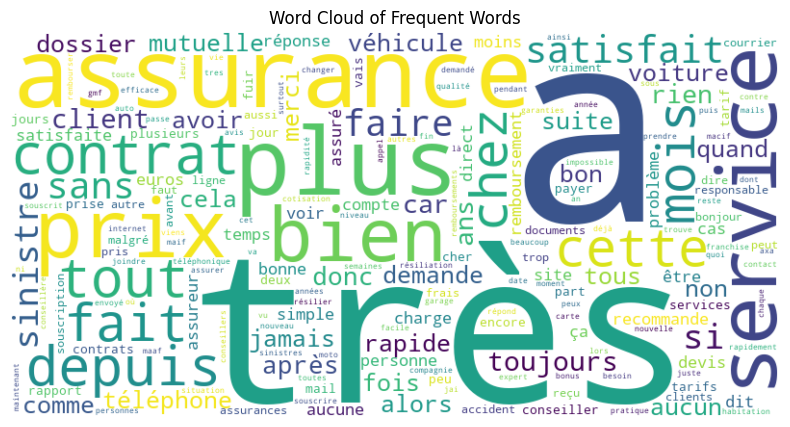

In [260]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Cloud for single words
wordcloud = (WordCloud(width=800, height=400, background_color='white', min_word_length=0).fit_words(word_counts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Frequent Words")
plt.show()

### Most common n-grams

The most common 2 and 3 grams will be displayed in a bar chart.

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,3))  # bigrams and trigrams
ngrams = vectorizer.fit_transform(df['avis'])

ngram_counts = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
ngram_counts.columns = ['Frequency']
ngram_counts = ngram_counts.sort_values(by='Frequency', ascending=False).head(100)

ngram_counts

,Frequency
cette assurance,2303
service client,2088
direct assurance,1830
satisfait service,1729
prise charge,1350
...,...
sinistre non,231
prendre charge,230
prise compte,226
nouveau contrat,226


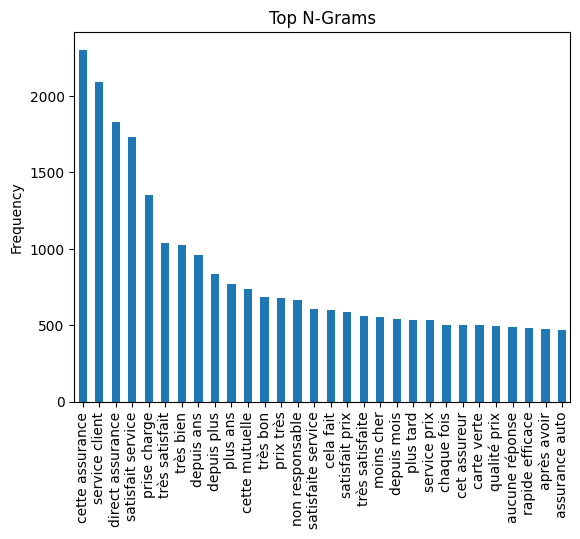

In [267]:
import matplotlib.pyplot as plt

ngram_counts.head(30).plot(kind='bar', legend=False)
plt.title("Top N-Grams")
plt.ylabel("Frequency")
plt.show()

# 3. Topic Modeling

In this section we will perform a topic modeling analysis. The found topics will be assigned to the reviews, and later used for category prediction (in the Modeling section).

## Topic Modeling with LDA

In this section we will perform a topic modeling analysis on the reviews using the Latent Dirichlet Allocation (LDA) algorithm.

4 Topics are identified and assigned to the reviews.

In [74]:
num_topics = 4

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)  # Adjust for French stopwords
tfidf_matrix = vectorizer.fit_transform(df['avis'])

# Get feature names
terms = vectorizer.get_feature_names_out()

from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics = display_topics(lda, terms, no_top_words=10)
print("Topics and their top words:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topics and their top words:
Topic 1: ans, plus, depuis, sinistre, bonus, assurance, sans, année, chez, augmentation
Topic 2: prix, satisfait, très, service, assurance, rapide, simple, recommande, bien, satisfaite
Topic 3: très, satisfaite, service, satisfait, merci, bon, téléphonique, bien, bonne, accueil
Topic 4: plus, mois, depuis, contrat, assurance, fait, toujours, faire, cette, tout


Given the 4 resulting topics and theri top words we can assign a title to each topic.

Topic 1: **Policy Claims**

The presence of words like ans (years), depuis (since), and augmentation (increase) suggests discussions about long-term experiences, possibly related to policy terms, claim history (sinistre), and premium increases.

Topic 2: **Satisfaction and Pricing**

Words like prix (price), satisfait (satisfied), and recommande (recommend) suggest reviews discussing pricing, satisfaction, and general feedback about service and value.

Topic 3: **Service Experience**

Words like téléphonique (phone), accueil (welcome), and service (service) imply feedback related to customer service interactions, especially over the phone.

Topic 4: **Contracts and Policy Management**

Words like contrat (contract), depuis (since), and fait (done) indicate discussions about contracts, durations, and issues regarding agreements or policies.

We can then annotate the topics in the dataset.



In [3]:
topic_labels = {
    1: "Policy Claims",
    2: "Satisfaction and Pricing",
    3: "Service Experience",
    4: "Contracts and Policy Management"
}


In [48]:
# Assign the most probable topic to each document
document_topics = lda.transform(tfidf_matrix)
df['topic'] = document_topics.argmax(axis=1) + 1

df['topic'] = df['topic'].map(topic_labels)

We can save the dataset with the assigned topics, as well as the model.

In [53]:
df.to_pickle(os.path.join(data_path, 'dataset_cleaned_topics.pkl'))

In [4]:
df = pd.read_pickle(os.path.join(data_path, 'dataset_cleaned_topics.pkl'))

In [76]:
import pickle
with open(os.path.join(models_path, 'lda_model.pkl'), 'wb') as file:
    pickle.dump(lda, file)

## Topic Visualization

We can use an heatmap to visualize the topics and their top words.

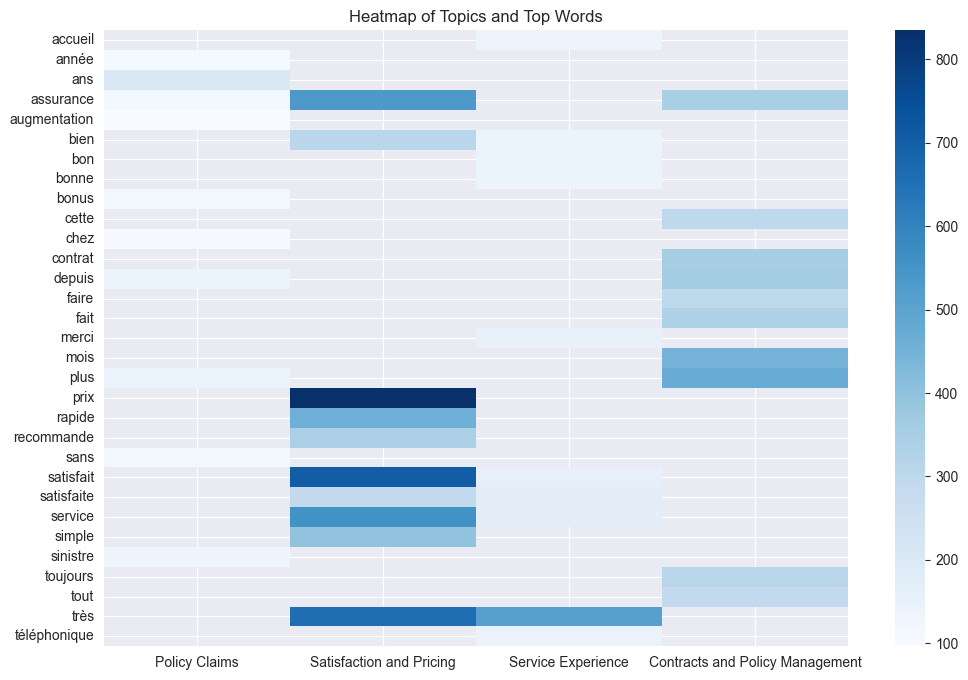

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe for heatmap
import pandas as pd
heatmap_data = pd.DataFrame(lda.components_, index=[f"{topic_labels[i+1]}" for i in range(num_topics)], columns=terms)
top_terms_per_topic = heatmap_data.apply(lambda x: x.nlargest(10), axis=1)  # Top 10 terms per topic

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_terms_per_topic.T, annot=False, cmap='Blues')
plt.title("Heatmap of Topics and Top Words")
plt.show()

The heatmap visually represents the relationship between the topics discovered during the topic modeling process and the most frequent words associated with each topic.

The columns represent the different topics derived from the topic modeling process. The rows represent the most frequent and meaningful words associated with these topics.

Words like "prix", "satisfait", and "service" are indicative of customer feedback about Satisfaction and Pricing. Words such as "contrat", "fait", and "toujours" strongly correspond to the topic "Contracts and Policy Management".

The lighter or darker shades of the heatmap reflect the frequency or relevance of a word to a particular topic. For instance:
- The word "satisfait" shows high relevance to the "Satisfaction and Pricing" topic.
- The word "augmentation" is closely tied to "Contracts and Policy Management", likely referencing customer concerns about contract or policy premium increases.
- The word "service" appears prominently under "Service Experience", highlighting its importance in that category.


We can identify dominant themes in customer feedback:
- "Satisfaction and Pricing" stands out for frequently discussed terms like "prix" and "recommande", indicating a strong focus on pricing and recommendations.
- "Policy Claims" is associated with words like "sinistre" and "augmentation", reflecting concerns about claims and related policies.
- "Service Experience" emphasizes terms like "très satisfait", "téléphonique", and "accueil", suggesting that customer interaction and support are critical.

# 4. Embedding to Identify Similar Words

In order to implement the embedding to identify similar words, we are going to develop a Word2Vec-based approach to analyze word relationships in French customer reviews.
It extends the basic Word2Vec functionality by allowing users to find similar words based on cosine or euclidean similarity.



## Preparation

The workflow for obtaining the similarity score is the following:
1. Retrieve the vector of the target word.
2. Loop through all other words in the vocabulary.
3. Compute the selected metric between the target word and each vocabulary word.
4. Sort the results based on the similarity or distance scores.
5. Return the top n words along with their similarity or distance scores.

In [67]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Train Word2Vec model
tokenized_reviews = [word_tokenize(review.lower()) for review in df['avis']]
model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Function to compute Euclidean distance
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Function to compute cosine similarity
def cosine_similarity_manual(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Function to find similar words with custom distance metrics
def find_similar_words(word, topn=10, metric="cosine"):
    if word not in model.wv:
        return f"Word '{word}' not in vocabulary."

    word_vector = model.wv[word]
    similarities = []

    for other_word in model.wv.index_to_key:
        if other_word == word:
            continue
        other_vector = model.wv[other_word]

        # Compute the specified distance metric
        if metric == "cosine":
            similarity = cosine_similarity_manual(word_vector, other_vector)
        elif metric == "euclidean":
            similarity = -euclidean_distance(word_vector, other_vector)  # Negate to sort by similarity
        else:
            raise ValueError("Invalid metric. Use 'cosine' or 'euclidean'.")

        similarities.append((other_word, similarity))

    # Sort and return top-n similar words
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:topn]

Words similar to 'prix' using cosine similarity:
tarif: 0.8719
tarifs: 0.8443
qualitéprix: 0.7711
proposez: 0.7641
prixje: 0.7601
tarification: 0.7539
rapideprix: 0.7524
serviceprix: 0.7490
relativement: 0.7431
lensemble: 0.7416


In [71]:
# Save the model
model.save(os.path.join(models_path, 'word2vec_model'))

### Test similarity

We can test the similarity function with a sample word to find similar words based on cosine similarity.

In [69]:
# Test with a sample word
word_to_check = "prix"  # Example word in French
metric = "cosine"  # Change to "euclidean" to test Euclidean distance

similar_words = find_similar_words(word_to_check, metric=metric)
print(f"Words similar to '{word_to_check}' using {metric} similarity:")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

Words similar to 'prix' using cosine similarity:
tarif: 0.8719
tarifs: 0.8443
qualitéprix: 0.7711
proposez: 0.7641
prixje: 0.7601
tarification: 0.7539
rapideprix: 0.7524
serviceprix: 0.7490
relativement: 0.7431
lensemble: 0.7416


The result highlights the words most similar to the target word prix, calculated using cosine similarity. Compound terms such as qualitéprix (quality-price) and tarification (pricing policy) indicate a focus on pricing structures and value perceptions in customer feedback. We can also notice that "prix" is strongly associated with key pricing-related themes, such as fairness, service-related costs, and customer expectations.

### t-SNE Visualization

We are going to plot a 2D visualization of word embeddings using the t-SNE algorithm. The embeddings were trained on the complite dataset of french reviews, and the dimensionality reduction enables us to observe relationships between words in a simplified two-dimensional space.

Only 200 words are selected for visualization to avoid cluttering the plot.

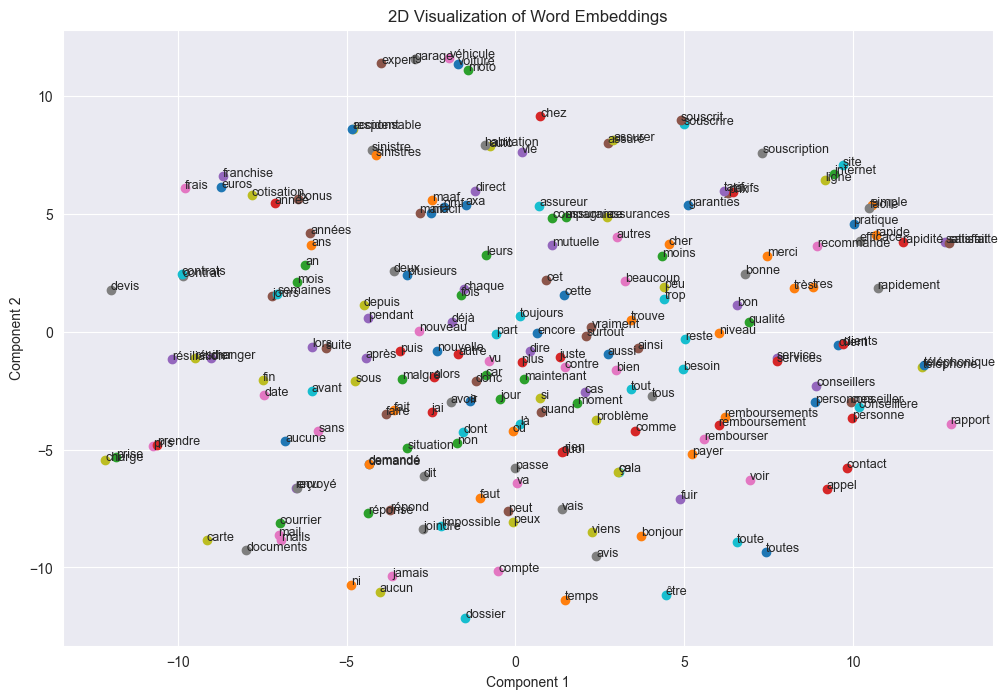

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions using t-SNE
words = list(model.wv.index_to_key)[:200]  # Limit to first 100 words for clarity
word_vectors = model.wv[words]
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_2d = tsne.fit_transform(word_vectors)

# Plot with Matplotlib
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=9)
plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

We can notice that words with similar meanings or contexts are grouped together, demonstrating the semantic structure captured by the Word2Vec model.

For example "satisfaite", "simple", "rapide" are clustered, indicating customer satisfaction and ease of service; "tarif", "rapport", "devis" are grouped, reflecting pricing-related discussions.

We can also find semantic relationships: words related to service experience (like "client", "service", "téléphonique") form a distinct region, just like words about documents and claims ("dossier", "contrat", "remboursement") which appear near each other.

# 5. 6. Modelling

We have decided to test all the the kind of different models proposed for the project, instead of choosing just one.
Therefore, in this section we will build and train various kind of models that aims to fulfill different tasks and use-cases on the dataset. Specifically, we will build:
- A sentiment analysis model using TF-IDF and classic ML
- A basic model with an embedding layer to predict the stars rating of reviews
- A model with pre-trained embeddings to classify reviews into predefined categories
- A model using Universal Sentence Embedding (USE) to perfoerm semantic search
- A LLM model to generate concise summaries of customer reviews for a specified insurer.

Each of these uses cases and their models are shown in the following subsections of this section.

Finally, notice that we have decided to use the reviews in their french version for all the following use cases, in order to make the training and model selection more challenging and interesting.

## TF-IDF and classic ML

In this section we'll predict binary sentiment classification (positive or negative sentiment) using TF-IDF and classical machine learning  (implementing a Logistic Regression).

### Data Preparation

First, the dataset will be labeled with “positive” if the rating is 4 or 5 and “negative” if the rating is 1 or 2. Ratings of 3 will be excluded to maintain a clear distinction between positive and negative classes.

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

reviews = df[['avis', 'note']].copy()

# Simplify sentiment into binary classification (positive or negative)
def label_sentiment(row):
    if row['note'] >= 4:
        return "positive"
    elif row['note'] <= 2:
        return "negative"
    else:
        return None

reviews['sentiment'] = reviews.apply(label_sentiment, axis=1)
reviews = reviews.dropna(subset=['sentiment'])  # Drop rows with neutral sentiment (3 stars)

#save the dataset
reviews.to_pickle(os.path.join(data_path, 'dataset_cleaned_sentiment.pkl'))

# Split data into training and test sets
X = reviews['avis']  # Preprocessed reviews
y = reviews['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Building and training

The model is built with the following steps:
1. **TF-IDF Vectorization**: The reviews are converted into TF-IDF features to represent the text data numerically.
2. **Logistic Regression**: A Logistic Regression model is trained on the TF-IDF features to classify reviews into positive or negative sentiment.


In [56]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9397

Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.96      0.94      2165
    positive       0.95      0.92      0.94      1980

    accuracy                           0.94      4145
   macro avg       0.94      0.94      0.94      4145
weighted avg       0.94      0.94      0.94      4145

Predicted Sentiment for 'Service client va bien.': positive


The model achieved a very high accuracy, indicating that it can effectively classify reviews into positive or negative sentiment based on their content.

The high accuracy can probably be justified by the clear distinction between positive and negative reviews, having removed the neutral review, as well as the effectiveness of TF-IDF features in capturing the sentiment of the reviews.

In [58]:
# Save the model
import os
import pickle

model_path = os.path.join(models_path, 'sentiment_analysis_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

### Model testing

The model is tested with a sample review to predict its sentiment.

In [57]:
# Example usage
example_review = "Service client va bien."
example_tfidf = vectorizer.transform([example_review])
predicted_sentiment = model.predict(example_tfidf)
print(f"Predicted Sentiment for '{example_review}': {predicted_sentiment[0]}")

Predicted Sentiment for 'Service client va bien.': positive


The model correctly predicted the sentiment of the sample review as positive, indicating that it is able to classify reviews effectively based on their content.

##  Basic Model with Embedding Layer

The model developed in this section aims to predict the star rating (on a scale from 1 to 5) of customer reviews using a basic neural network with an embedding layer. This model will learn word representations directly from the dataset, making it well-suited for handling vocabulary and context specific to the reviews.

### Data Preparation

As first step, the textual data is preprocessed by splitting the data into training and test sets, scaling the target star ratings to the range [0, 1], and tokenizing and padding the review text into uniform sequences. Invalid target values are removed to ensure the data is clean and suitable for training the neural network.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.initializers import RandomUniform

# Load the dataset
reviews = df[['avis', 'note']].copy()

# Prepare data: Input (reviews) and target (star ratings)
X = reviews['avis']  # Preprocessed reviews
y = reviews['note']  # Star ratings (1-5)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale target values to the range [0, 1]
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 100  # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Remove or replace invalid targets
valid_indices = ~pd.isnull(y_train_scaled).ravel()
X_train_padded = X_train_padded[valid_indices]
y_train_scaled = y_train_scaled[valid_indices]

valid_indices = ~pd.isnull(y_test_scaled).ravel()
X_test_padded = X_test_padded[valid_indices]
y_test_scaled = y_test_scaled[valid_indices]

### Model Building and Training

The model is built with the following caracteristics:
- **Embedding Layer**: The network starts with an embedding layer, which maps each word to a dense vector representation of fixed size. This layer is trained during the model fitting, enabling the network to learn semantic relationships between words. Instead of using pre-trained embeddings, we let the model learn embeddings specific to the dataset, capturing unique word usage patterns in customer reviews.
- **Global Average Pooling**: A global average pooling layer aggregates the word embeddings for each review, providing a fixed-size representation regardless of the review length. This layer simplifies the model by aggregating information from all words in a review into a single fixed-length vector, reducing computational complexity and overfitting risk.
- **Fully Connected Dense Layer**: A fully connected dense layer applies non-linear transformations to learn complex patterns.
- **Regression Output**: The final output layer is a single neuron with a linear activation function, designed to predict a continuous value (the star rating).
- **Optimization**: Adam optimizer with gradient clipping is used to prevent issues like exploding gradients.


In [8]:
# Build a neural network with an embedding layer
embedding_dim = 50  # Dimension of word embeddings

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              embeddings_initializer=RandomUniform(minval=-0.05, maxval=0.05)),  # Proper initialization
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error

# Train the model
history = model.fit(X_train_padded, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_padded, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

Epoch 1/10


/opt/anaconda3/envs/Project1-MachineLearningForNLP/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1056 - mae: 0.2724 - val_loss: 0.0581 - val_mae: 0.1950
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0540 - mae: 0.1869 - val_loss: 0.0605 - val_mae: 0.1959
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476 - mae: 0.1731 - val_loss: 0.0485 - val_mae: 0.1728
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0406 - mae: 0.1567 - val_loss: 0.0494 - val_mae: 0.1792
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0376 - mae: 0.1492 - val_loss: 0.0487 - val_mae: 0.1701
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342 - mae: 0.1422 - val_loss: 0.0471 - val_mae: 0.1727
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0325 - mae: 0.1369 - val_loss: 0.0579 - val_mae: 0.1862
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0290 - mae: 0.1293 - val_loss: 0.0489 - val_mae: 0.1701
Epoch 9/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0272 

The MSE loss decreases steadily and the MAE drops over 10 epochs: this shows that the model is learning effectively on the training data.

The validation MSE stabilizes around 0.05, and the MAE converged around 0.17: these values are close to the training metrics, indicating that the model generalizes well and is not overfitting.

Finally, on the test set, the MSE and the MAE obtained align closely with the validation performance.

In [74]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,509,989 (5.76 MB)

 Trainable params: 503,329 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,006,660 (3.84 MB)

In [13]:
# Save the model
model.save(os.path.join(models_path, 'star_rating_prediction_model.keras'))

### Model testing

The goal of this task is to predict star ratings based on review text: here we test the trained model with a sample review and evaluate its performance.

This implementation demonstrates the power of embeddings and basic neural networks in regression tasks, bridging textual and numerical data effectively.

In [9]:
# Example usage
example_review = "Service rapide et excellent."
example_seq = tokenizer.texts_to_sequences([example_review])
example_padded = pad_sequences(example_seq, maxlen=max_len, padding='post')
predicted_rating_scaled = model.predict(example_padded)
predicted_rating = scaler.inverse_transform(predicted_rating_scaled)
print(f"Predicted Rating for '{example_review}': {predicted_rating[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Rating for 'Service rapide et excellent.': 4.37


The predicted rating for the sample review is around 4.4, which makes sense for a review indicating high customer satisfaction. The prediction aligns with expectations, showcasing the model’s ability to interpret text sentiment accurately.

## Model with pre-trained embeddings

The model developed in this section aims to classify customer reviews into predefined categories (e.g., Pricing, Customer Service, etc.) using pre-trained embeddings. The embeddings capture semantic relationships between words and serve as input to a simple neural network for classification.

The development process involves the following steps:
1. Load pre-trained word embeddings (GloVe).
2. process the reviews (tokenize and pad).
3. Map the tokens to their pre-trained embedding vectors.
4. Train of a simple neural network on the embedding representations to classify reviews into categories.

### Data Preparation

The dataset and pre-trained embeddings are prepared for the neural network to classify reviews into predefined topics. The reviews are tokenized into sequences of integers and padded to ensure uniform length, while the target categories are converted into a one-hot encoded format for multi-class classification.

Next, pre-trained GloVe embeddings are loaded, which provide dense vector representations for words. An embedding matrix is constructed, where each row corresponds to a word in the vocabulary, and its values are initialized with the corresponding GloVe embedding if available. This matrix will later be used in the embedding layer of the neural network to incorporate semantic knowledge into the model.

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
import zipfile

# Load the dataset
# Replace this with the actual dataset path or loading code

# Prepare data: Input (reviews) and target (categories)
X = df["avis"]
y = pd.get_dummies(df['topic'])  # Convert categories to one-hot encoding

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 50       # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Load pre-trained GloVe embeddings
embedding_dim = 50
embedding_index = {}

if not os.path.exists("glove.6B.50d.txt"):
    with zipfile.ZipFile("glove.6B.50d.txt.zip", "r") as z:
        z.extractall()

with open("glove.6B.50d.txt", encoding="utf-8") as f:  # Update to your GloVe file path
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Prepare the embedding matrix
word_index = tokenizer.word_index
num_tokens = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Model Building and Training

The model is built with the following layers, trying to simplicity and performance:

1. **Embedding Layer**: This layer initializes word embeddings with the pre-trained GloVe embeddings stored in the embedding_matrix. By using pre-trained embeddings, the model benefits from prior knowledge of word meanings, which enhances performance even with limited labeled data.
2. **Global Average Pooling Layer**: This layer reduces the sequence of word embeddings into a single fixed-length vector by averaging the embeddings across all words in a review. It simplifies the model by aggregating information, reducing the risk of overfitting, and ensuring that the input size is fixed regardless of the sequence length.
3. **Dense Layer (Hidden Layer)**: A fully connected layer with 64 units and a ReLU activation function introduces non-linearity to the model, allowing it to learn complex patterns in the data.
4. **Output Layer**: The output layer uses a softmax activation function and has as many neurons as the number of target categories (y_train.shape[1]), making it suitable for multi-class classification. The softmax function ensures that the outputs are probabilities for each category, allowing easy interpretation.

The model uses categorical crossentropy, which is the standard loss function for multi-class classification. It measures the difference between the predicted probability distribution and the true distribution. Additionally, the Adam optimizer is chosen for its efficiency and ability to adapt learning rates during training, leading to faster convergence.

In [21]:
# Set up TensorBoard log directory
log_dir = "tensorflow_logs/category_embeddings"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Prepare metadata for embeddings (word to index mapping)
metadata_path = os.path.join(log_dir, "metadata.tsv")
with open(metadata_path, "w") as f:
    for word, i in word_index.items():
        if i < max_words:
            f.write(f"{word}\n")

In [22]:
# Build the model
model = Sequential([
    Embedding(input_dim=num_tokens,
              output_dim=embedding_dim,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=max_len,
              trainable=True),  # Freeze embeddings
    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/opt/anaconda3/envs/Project1-MachineLearningForNLP/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6368 - loss: 0.9360 - val_accuracy: 0.7914 - val_loss: 0.5271
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8245 - loss: 0.4570 - val_accuracy: 0.8484 - val_loss: 0.3845
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8783 - loss: 0.3193 - val_accuracy: 0.8188 - val_loss: 0.4559
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9024 - loss: 0.2582 - val_accuracy: 0.8695 - val_loss: 0.3301
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9225 - loss: 0.2087 - val_accuracy: 0.8769 - val_loss: 0.3183
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9400 - loss: 0.1667 - val_accuracy: 0.8851 - val_loss: 0.3172
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9528 - loss: 0.1377 - val_accuracy: 0.8811 - val_loss: 0.3298
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9608 - loss: 0.1129 - val_accuracy: 0.8804 - val_

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,510,574 (5.76 MB)

 Trainable params: 503,524 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,007,050 (3.84 MB)

In [12]:
# Save the model
model.save(os.path.join(models_path, 'topic_classification_model.keras'))

### Model testing

The goal of this task is to predict the category of a review based on its content. Here we test the trained model with a sample review and evaluate its performance.

In [23]:
# Example prediction
example_review = "Prix raisonnables pour un bon service"
example_seq = tokenizer.texts_to_sequences([example_review])
example_padded = pad_sequences(example_seq, maxlen=max_len, padding='post')
predicted_category = model.predict(example_padded)
category_labels = y.columns
predicted_label = category_labels[np.argmax(predicted_category)]
print(f"Predicted Category for '{example_review}': {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Category for 'Prix raisonnables pour un bon service': Satisfaction and Pricing


The predicted category for the sample review is "Satisfaction and Pricing," which aligns with the content of the review. The model successfully classified the review into the correct category, demonstrating its ability to generalize and make accurate predictions on unseen data.

In [24]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
import tensorflow as tf
import os
import numpy as np

# Save the embedding weights
weights = model.layers[0].get_weights()[0]
embedding_weights_path = os.path.join(log_dir, "embedding_weights.tsv")
np.savetxt(embedding_weights_path, weights, delimiter="\t")

embedding_var = tf.Variable(weights, name="embedding_weights")

# Create a checkpoint
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint_path = log_dir + "/embedding.ckpt"
checkpoint.write(checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

# Write summary for TensorBoard projector
writer = tf.summary.create_file_writer(log_dir)
with writer.as_default():
    tf.summary.text("Metadata", metadata_path, step=0)

print(f"Embedding visualization files saved to {log_dir}. Run TensorBoard to view embeddings:")
print(f"tensorboard --logdir={log_dir}")

Checkpoint saved to tensorflow_logs/category_embeddings/embedding.ckpt
Embedding visualization files saved to tensorflow_logs/category_embeddings. Run TensorBoard to view embeddings:
tensorboard --logdir=tensorflow_logs/category_embeddings


In [20]:
%tensorboard --logdir tensorflow_logs/category_embeddings

Reusing TensorBoard on port 6006 (pid 17131), started 0:02:01 ago. (Use '!kill 17131' to kill it.)

## USE (Universal Sentence Embedding)

Semantic search uses embeddings to retrieve the most relevant documents (reviews, in this case) based on their semantic similarity to a query. In this use case, we will use the Universal Sentence Encoder (USE) to encode both reviews and search queries into dense vectors. By calculating cosine similarity between the query and the reviews, we can retrieve and rank the most relevant reviews.

### Preliminary steps

Each review and query is converted into a 512-dimensional dense vector using the USE model.

In [35]:
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the Universal Sentence Encoder model
print("Loading Universal Sentence Encoder...")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print("Model loaded!")

# Encode all reviews using the Universal Sentence Encoder
print("Encoding reviews...")
review_embeddings = embed(df["avis"].tolist())
print("Reviews encoded!")

#save the embeddings
np.save(os.path.join(models_path, 'review_embeddings.npy'), review_embeddings)

Loading Universal Sentence Encoder...
Model loaded!
Encoding reviews...
Reviews encoded!


### Semantic Search

The semantic search function takes a query as input and computes the cosine similarity between the query embedding and all review embeddings. The reviews are then ranked based on their similarity scores, and the top-k most similar reviews are returned along with their scores.

In [34]:
# Function to perform semantic search
def semantic_search(query, embeddings, top_k=3):
    # Encode the query
    query_embedding = embed([query])

    # Compute cosine similarity between query and all reviews
    similarities = cosine_similarity(query_embedding, embeddings).flatten()

    # Get the indices of the top_k most similar reviews
    top_indices = similarities.argsort()[-top_k:][::-1]

    # Return the top_k most similar reviews with their similarity scores
    results = [
        {
            "avis": df["avis"].iloc[i],
            "assureur": df["assureur"].iloc[i],
            "produit": df["produit"].iloc[i],
            "score": similarities[i]
        }
        for i in top_indices
    ]
    return results

# Example Query
query = "Quel est le service client le plus rapide ?"
top_results = semantic_search(query, review_embeddings, top_k=3)

# Display the results
print(f"\nQuery: {query}")
print("Top Results:")
for result in top_results:
    print(
        f"- Review: {result['avis']}\n"
        f"  Assureur: {result['assureur']}\n"
        f"  Product: {result['produit']}\n"
        f"  Similarity Score: {result['score']:.4f}\n"
    )


Query: Quel est le service client le plus rapide ?
Top Results:
- Review: prix service plus compétitif service client présent répond rapidement questions démarches via internet très simple rapide
  Assured: Direct Assurance
  Product: auto
  Similarity Score: 0.6277

- Review: service client tout simplement déplorable
  Assured: MAIF
  Product: habitation
  Similarity Score: 0.5896

- Review: super service client merci a professionnalisme rapide très efficace fait assuré quelque minutes vraiment top
  Assured: Direct Assurance
  Product: auto
  Similarity Score: 0.5884



The semantic search function successfully retrieved the most relevant reviews based on the query, demonstrating the effectiveness of semantic search in retrieving information from a large corpus of reviews.

## LLM

I this seciton we are going to use the "t5-base-fr-sum-cnndm" model to generate concise summaries of customer reviews for a specified insurer.

The goal is to summarize the key points, including positive and negative aspects. The summarization process is developed considering the computational constraints and ensure meaningful output.

### Model Definition

The reviews of the given assureur are first deduplicated using list(set(reviews)) to remove redundant content. This reduces input noise and ensures the summarization focuses on unique feedback.

Only 50 reviews are used per assureur, and the input is capped at 1024 tokens to meet the model’s computational constraints and tokenization limits, in order to limit the risk of memory errors and ensures efficient processing.

A guiding prompt instructs the model to summarize the reviews in one or two sentences, highlighting positive and negative aspects. This helps the model focus on generating structured and concise outputs.

Only the first sentence of the output is retained to ensure the summary is brief and captures the main points effectively.

In [65]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Load the model and tokenizer
model_name = "plguillou/t5-base-fr-sum-cnndm"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def get_first_sentence(text):
    # Find the position of the first period
    period_pos = text.find('.')

    # If a period is found, return the substring up to and including the period
    if period_pos != -1:
        return text[:period_pos + 1]

    # If no period is found, return the entire text
    return text

# Summarization function
def generate_insurer_summary(insurer_name, df):
    # Filter reviews for the specified insurer
    reviews = df[df['assureur'] == insurer_name]['avis'].tolist()
    reviews = list(set(reviews))
    
    # Aggregate reviews into a single input
    aggregated_reviews = "\n".join([f"- {review}" for review in reviews[:50]])

    # Add a guiding prompt
    prompt = (
            f"Voici des avis des clients pour l'assureur {insurer_name}. Résumez ces avis en français en une ou deux phrases, en mettant en évidence "
            "les points positifs, les points négatifs:\n"
            + aggregated_reviews
    )

    # Summarize the reviews
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=80, min_length=10, length_penalty=3, num_beams=4)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    summary = get_first_sentence(summary)
    return summary

In [64]:
# save the model
import os

model.save_pretrained(os.path.join(models_path, 't5-base-fr-sum-cnndm'))

### Model Testing

The model is tested with a assureur to generate a summary of customer reviews.

In [66]:
# Direct Assurance
# Zen'Up
# Generali
# LCL
insurer_name = "Zen'Up"
summary = generate_insurer_summary(insurer_name, df)
print(f"Summary for {insurer_name}:\n{summary}")

Summary for Zen'Up:
Les clients de Zen'Up ont exprimé leur satisfaction à l'égard du service et de l'efficacité de l'assureur.


This implementation effectively balances computational efficiency and output quality. By limiting the input size, carefully designing the prompt, and post-processing the generated text, the model produces clear and concise summaries tailored for insurer reviews.

Testing different inputs, we can conclude that, generally speaking, on average the model delivers good summaries of the reviews, considering the simplicity of the model and the constraints of the task.

# 7. Streamlit Applications